# Finding Donors for Charity ML

### This is my extended solution for Udacity's Data Scientist Nanodegree first project

This is not the version that was submitted for grading. I decided to improve the scope of the analysis and add several more methods which were not contained in Udacity's rubrics.

**This test version does not remove the extreme lines and it does not apply log transform.**

### Original text by Udacity

## Description

CharityML is a fictitious charity organization located in the heart of Silicon Valley that was established to provide financial support for people eager to learn machine learning. After nearly 32,000 letters were sent to people in the community, CharityML determined that every donation they received came from someone that was making more than $50,000 annually. To expand their potential donor base, CharityML has decided to send letters to residents of California, but to only those most likely to donate to the charity. With nearly 15 million working Californians, CharityML has brought you on board to help build an algorithm to best identify potential donors and reduce overhead cost of sending mail. Your goal will be evaluate and optimize several different supervised learners to determine which algorithm will provide the highest donation yield while also reducing the total number of letters being sent.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Loading and describing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
%matplotlib inline

In [2]:
# read data from data folder
data = pd.read_csv('data/census.csv')

In [3]:
# check a sample of the dataframe
data.head(n=5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [4]:
# number of dataset records
n_records = data.shape[0]
print('Dataset has %d records'% n_records)

Dataset has 45222 records


In [5]:
# general information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


**The dataset is composed of 45222 records and 14 columns. There are no missing entries. The records are numerical (int64 and float64) or text (object).**

In [6]:
# 5-number data summary
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


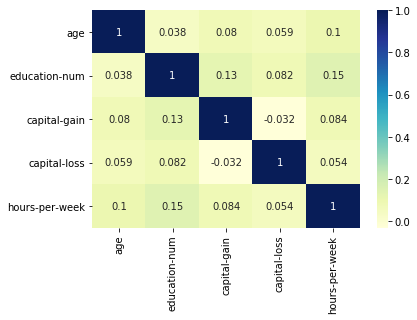

In [7]:
# Pearson's correlation coefficient for the numerical variables
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu");

**Some of the features are weakly correlated. It is unlikely this will affect the classification outcome.**

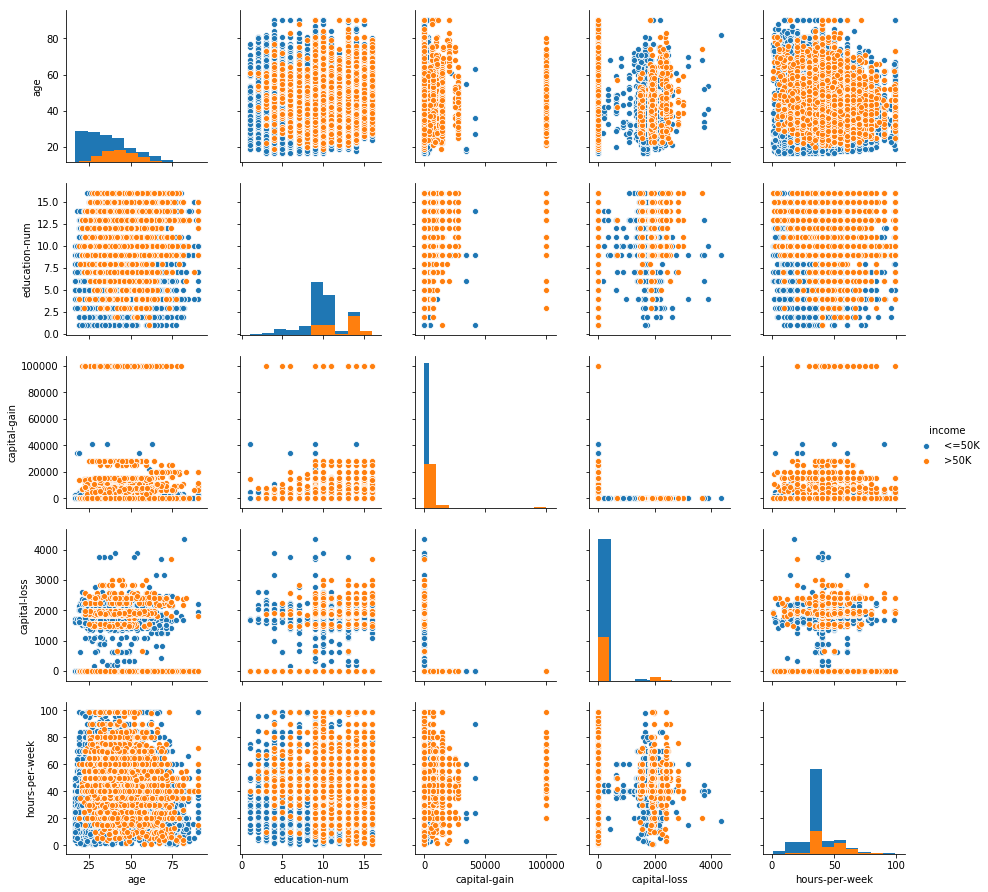

In [8]:
# visually inspect all the combinations of numerical variables
sns.pairplot(data, hue='income', diag_kind='hist');

**None of the features follow a Normal distribution. Capital-gain shows a very suspicious line at 99999. Is this some census code for non-declared value? We will need to replace these points. It is also clear that the features are not correlated.**

In [9]:
# There are 229 entries with capital-gain = 99999.0. That's not a lot.
data[data['capital-gain'] == data['capital-gain'].max()]['capital-gain'].count()

229

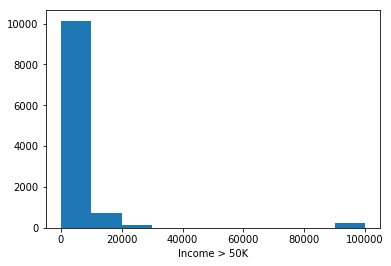

In [10]:
# Histogram of capital-gain before cleaning shows the outliers.
plt.hist(data[data['income']=='>50K']['capital-gain']);
plt.xlabel('Income > 50K');

In [11]:
# We remove the outliers in capital-gain by first turning all outliers into nan
#data.loc[data['capital-gain']==99999.0,'capital-gain']  = np.nan

In [12]:
#data.loc[data['capital-loss']==0.0,'capital-loss']  = np.nan

In [13]:
# and then applying fillna. We use mean as replacement method because median returns 0.
#data = data.fillna(data[data['income']=='>50K']['capital-gain'].mean())

In [14]:
#data = data.fillna(data[data['income']=='<=50K']['capital-loss'].mean())

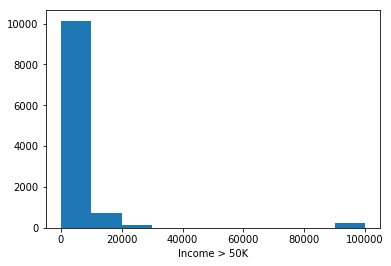

In [15]:
# The histogram after replacement looks much better.
plt.hist(data[data['income']=='>50K']['capital-gain']);
plt.xlabel('Income > 50K');

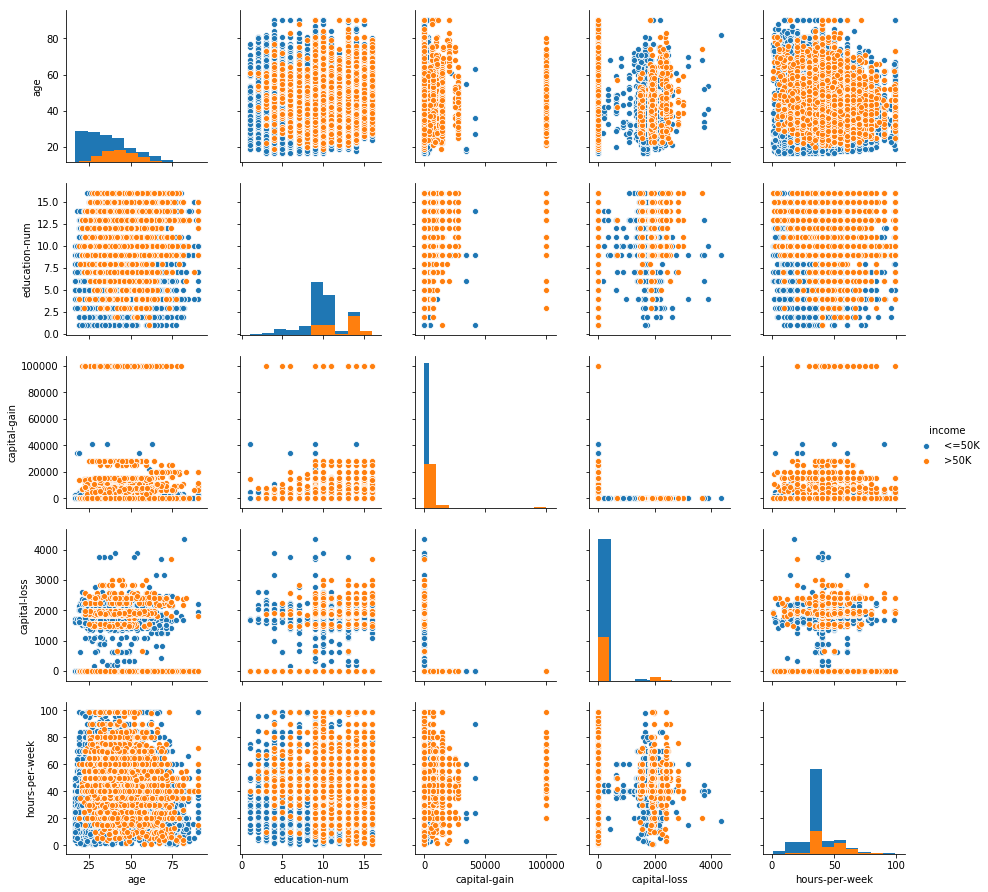

In [16]:
# Finally we check pairplot again
sns.pairplot(data, hue='income', diag_kind='hist');

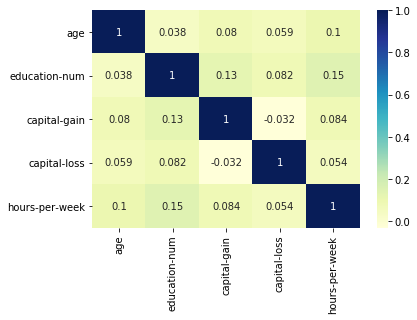

In [17]:
# and calculate the correlation coefficient for the modified dataset.
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")

**Correlation between capital-gain and capital loss slightly increased but it still small.**

In [18]:
# Last, we check the data summary for modified dataset.
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


## Preparing the data

This is the sequence for data preparation:

1-  generate target array by selecting incomes >50K
2- 

Udacity recommended us to use a log transformation with capital-gain and capital-loss. I removed this transformation because it was not anymore needed after the outliers were eliminated from the dataset.

In [19]:
# First we define the number of entries with income greater than 50K
n_greater_50k = data[data['income'] == '>50K']['income'].count()

print('Dataset has %d individuals earning more than $50,000 annually' % n_greater_50k)

Dataset has 11208 individuals earning more than $50,000 annually


In [20]:
# and then the number of entries with income at most equal to 50K.
n_at_most_50k = data[data['income'] == '<=50K']['income'].count()

print('Dataset has %d individuals earning at most $50,000 annually' % n_at_most_50k)

Dataset has 34014 individuals earning at most $50,000 annually


In [21]:
# Next we check for consistency of number of entries
n_records == n_greater_50k + n_at_most_50k 

True

In [22]:
# and calculate the percentage of entries with income greater than 50K.
greater_percent = n_greater_50k / n_records * 100

print('{:4.2f}% of the individuals earn more than $50,000 annually'.format(greater_percent))

24.78% of the individuals earn more than $50,000 annually


**Only 25% of the entries earn more than 50K. This means that the dataset is skewed and accuracy is not a good metric for this problem. I will keep using it but I will take the decisions about the model based on F1 score.**

In [23]:
# separate target column from dataset for preprocessing. 
income_raw = data['income']
# define new feature dataset without target column.
features_raw = data.drop('income', axis=1)

### Normalizing Numerical Features

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
# Create MinMaxScaler object
scaler = MinMaxScaler()

In [26]:
# According to data.info() the numerical variables are:
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# Create new dataframe with scaled features
features_scaled = features_raw.copy()
features_scaled[numerical] = pd.DataFrame(scaler.fit_transform(features_raw[numerical]))

/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [27]:
# Inspect new dataframe
features_scaled.head(n=5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


In [28]:
features_scaled.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.295177,0.607897,0.011014,0.020339,0.407531
std,0.181067,0.170192,0.075065,0.092965,0.122526
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.600000,0.000000,0.000000,0.397959
75%,0.410959,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000,1.000000


### One-hot encoding of object features

In [29]:
# Create new dataframe with one-hot encoded object features
features_final = pd.get_dummies(features_scaled) # another option would be sklearn OneHotEncoder()

In [30]:
# Shape of previous dataframe
features_scaled.shape

(45222, 13)

In [31]:
# Shape of one-hot encoded dataframe
features_final.shape

(45222, 103)

In [32]:
# Map target column from strings to (0,1) range.
# Incomes >50K map to 1
income = income_raw.map(lambda x: 0 if x=='<=50K' else 1)

In [33]:
# Print list of features after one-hot encoding
encoded = list(features_final.columns)

### Shuffle and Split Data

So far we removed the outliers from capital-gain, min-max scaled numerical features and one-hot encoded the object (categorical) features. Next we shuffled the dataset and split it into a training set and a testing set.

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# Split features and target into train and test data
# Don't use test set for model evaluation
X_train, X_test, y_train, y_test = train_test_split(
    features_final, income, test_size=0.2, random_state=0)

In [36]:
print('Training set has {} samples'.format(X_train.shape[0]))
print('Testing set has {} samples'.format(X_test.shape[0]))

Training set has 36177 samples
Testing set has 9045 samples


## Applying models and evaluating performace

### Baseline - Naive Predictor

We first calculated accuracy, recall, precision and the F1 score for a naive predictor as a baseline for the performance measurement of the classification methods. The naive predictor classifies all entries as Positives.

In [37]:
# True positives without False Negatives - sum the ones
TP = np.sum(income)
# False positives without True negatives - sum all and subtract from TP
FP = income.count() - TP
# There are no True Negatives nor False Negatives
TN = FN = 0

In [38]:
# Calculate metrics
accuracy = (TP + TN) / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

In [39]:
# Calculate F1 score
beta = 1.0
fscore = (1 + beta**2) * (precision * recall) / ( recall + (precision * beta**2))

In [40]:
print("Naive predictor: [Accuracy Score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive predictor: [Accuracy Score: 0.2478, F-score: 0.3972]


###  Supervised Learning Models

We now chose five models for training and assessed which one had a better performance classifying the dataset.

In [41]:
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [42]:
'''
This function trains and evaluates a model using a defined sample size.

INPUT:
    model - instantiated sklearn model
    sample_size - number of entries to be taken from training set
    X_train - numpy array or pandas dataframe with training features
    y_train - numpy array or pandas dataframe with target values
    
OUTPUT:
    results - dictionary containing the performance parameters for the model
    
'''

def trainPredict(model, sample_size, X_train, y_train):
    results = {}
    
    # shuffle training and target data and return array with n_samples elements
    X_train_shuffled, y_train_shuffled = shuffle(X_train.values, 
                                                 y_train.values, 
                                                 n_samples = sample_size)
    
    # fit training data and measure time
    start = time()
    model.fit(X_train_shuffled, y_train_shuffled)
    end = time()
    results['train_time'] = end - start
    
    # predict using the first 300 elements of training set and measure time
    start = time()
    predictions_train = model.predict(X_train[:300])
    # evaluate accuracy and F1 scores using 3-fold cross-validation
    # I cannot use X_test here because this is still a step of model selection
    accuracy_crossval = cross_val_score(model, 
                                        X_train_shuffled, 
                                        y_train_shuffled, 
                                        cv=3, 
                                        scoring='accuracy')
    f1_crossval = cross_val_score(model, 
                                  X_train_shuffled, 
                                  y_train_shuffled, 
                                  cv=3, 
                                  scoring='f1')
    end = time()
    results['pred_time'] = end - start
    
    # calculate accuracy using the first 300 entries of training set
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    # average accuracy score calculated using 3-fold cross validation
    results['acc_cv'] = accuracy_crossval.mean()
    # compute F1 score using the first 300 samples of training set
    results['f1_train'] = fbeta_score(y_train[:300], predictions_train, beta=1.0)
    # average F1 score calculated using 3-fold cross validation
    results['f1_cv'] = f1_crossval.mean()
    print("{} trained on {} samples".format(model.__class__.__name__, sample_size))
    
    return results

In [43]:
# Import supervised learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [44]:
# Intantiate the models
clf_A = DecisionTreeClassifier(random_state=34)
clf_B = AdaBoostClassifier(random_state=34)
clf_C = LogisticRegression(random_state=34, solver='lbfgs')
clf_D = RandomForestClassifier(random_state=34)
clf_E = GaussianNB()

In [45]:
# Calculate number of entries corresponding to 1%, 10%, 100% of total entries
# 1% of training entries
samples_1 = int(0.01 * X_train.shape[0]) 
# 10% of training entries
samples_10 = int(0.1 * X_train.shape[0])
# 100% of training entries
samples_100 = X_train.shape[0]

In [46]:
# Collect results on the learners
results = {}

for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    clf_name = clf.__class__.__name__
    results[clf_name]={}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = trainPredict(clf, samples, X_train, y_train)

DecisionTreeClassifier trained on 361 samples
DecisionTreeClassifier trained on 3617 samples
DecisionTreeClassifier trained on 36177 samples
AdaBoostClassifier trained on 361 samples
AdaBoostClassifier trained on 3617 samples
AdaBoostClassifier trained on 36177 samples
LogisticRegression trained on 361 samples


/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression trained on 3617 samples


/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase t

LogisticRegression trained on 36177 samples
RandomForestClassifier trained on 361 samples
RandomForestClassifier trained on 3617 samples
RandomForestClassifier trained on 36177 samples
GaussianNB trained on 361 samples
GaussianNB trained on 3617 samples
GaussianNB trained on 36177 samples


In [47]:
# Metrics visualization for the supervised learning process
# first convert dict to pandas dataframe
df2 = pd.DataFrame.from_dict({(i,j): results[i][j] for i in results.keys() 
                              for j in results[i].keys()}, orient='index')
df2.reset_index(inplace=True)
d2 = {0:'1%',1:'10%',2:'100%'}
df2['dataP'] = df2['level_1'].map(d2)
df2.rename(index=str, columns={'level_0':'model'}, inplace=True)

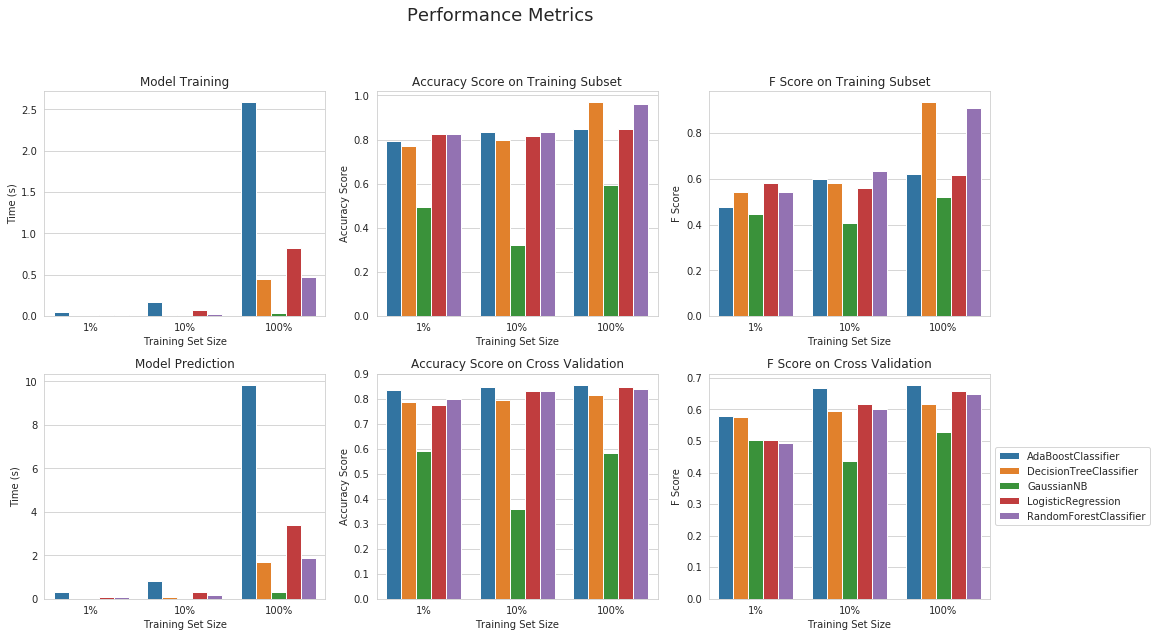

In [48]:
# then plot using Seaborn
with sns.axes_style('whitegrid',{'axes.facecolor':'white'}):
    f, axes = plt.subplots(2,3, figsize=(14,8))
    plt.suptitle('Performance Metrics', y=1.1, fontsize=18)
    sns.barplot(x='dataP',y='train_time',hue='model',data=df2, ax=axes[0][0])
    axes[0][0].set_title('Model Training')
    axes[0][0].set_xlabel('Training Set Size')
    axes[0][0].set_ylabel('Time (s)')
    axes[0][0].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='acc_train',hue='model',data=df2, ax=axes[0][1])
    axes[0][1].set_title('Accuracy Score on Training Subset')
    axes[0][1].set_xlabel('Training Set Size')
    axes[0][1].set_ylabel('Accuracy Score')
    axes[0][1].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='f1_train',hue='model',data=df2, ax=axes[0][2])
    axes[0][2].set_title('F Score on Training Subset')
    axes[0][2].set_xlabel('Training Set Size')
    axes[0][2].set_ylabel('F Score')
    axes[0][2].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='pred_time',hue='model',data=df2, ax=axes[1][0])
    axes[1][0].set_title('Model Prediction')
    axes[1][0].set_xlabel('Training Set Size')
    axes[1][0].set_ylabel('Time (s)')
    axes[1][0].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='acc_cv',hue='model',data=df2, ax=axes[1][1])
    axes[1][1].set_title('Accuracy Score on Cross Validation')
    axes[1][1].set_xlabel('Training Set Size')
    axes[1][1].set_ylabel('Accuracy Score')
    axes[1][1].get_legend().set_visible(False)
    sns.barplot(x='dataP',y='f1_cv',hue='model',data=df2, ax=axes[1][2])
    axes[1][2].set_title('F Score on Cross Validation')
    axes[1][2].set_xlabel('Training Set Size')
    axes[1][2].set_ylabel('F Score')
    axes[1][2].get_legend().set_visible(False)
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5))

In [49]:
# inspect actual training parameters for the models
df2

,model,level_1,train_time,pred_time,acc_train,acc_cv,f1_train,f1_cv,dataP
0,AdaBoostClassifier,0,0.050419,0.319839,0.793333,0.836593,0.474576,0.580586,1%
1,AdaBoostClassifier,1,0.166545,0.831797,0.833333,0.846000,0.596774,0.667944,10%
2,AdaBoostClassifier,2,2.588690,9.845755,0.850000,0.855848,0.621849,0.678384,100%
3,DecisionTreeClassifier,0,0.001653,0.012710,0.770000,0.786999,0.543046,0.576645,1%
4,DecisionTreeClassifier,1,0.017840,0.078441,0.800000,0.793198,0.583333,0.594437,10%
5,DecisionTreeClassifier,2,0.450635,1.700823,0.970000,0.813030,0.934307,0.617088,100%
6,GaussianNB,0,0.000998,0.011907,0.493333,0.589991,0.445255,0.503121,1%
7,GaussianNB,1,0.003510,0.033650,0.323333,0.357204,0.408163,0.436374,10%
8,GaussianNB,2,0.043863,0.329209,0.593333,0.584322,0.519685,0.527921,100%
9,LogisticRegression,0,0.015178,0.066522,0.823333,0.772842,0.582677,0.503059,1%


**AdaBoost had the best cross-validation performance with the full dataset. Decision Tree performed well with the small dataset (300 entries) and logistic regression performed surprisingly well.**

In [50]:
from itertools import product

In [51]:
def plotModel(clf, df, col1, col2, ax, nPlot):
#def plotModel(clf, df, col1, col2, nPlot):
    nPoints = nPlot**2
    df2 = df[0:nPoints].copy()
    X = df2[col1]
    Y = df2[col2]
    x_min, x_max = X.min() , X.max()
    y_min, y_max = Y.min() , Y.max() 
    xRange = np.linspace(x_min, x_max, num=nPlot)
    yRange = np.linspace(y_min, y_max, num=nPlot)
    xx, yy = np.meshgrid(xRange, yRange)
    df3 = pd.DataFrame(list(product(xx.ravel(),yy.ravel())), columns=[col1,col2])
    df2.update(df3[col1])
    df2.update(df3[col2])
    Z = clf.predict(df2)
    Z = Z.reshape(xx.shape)

#    fig, ax = plt.subplots(1)
    ax.set_title(str(clf.__class__.__name__))
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.contourf(xx, yy, Z, cmap = plt.cm.RdYlBu, alpha=0.5)
    scFig = ax.scatter(df2.iloc[0:nPoints,df2.columns.get_loc(col1)], 
           df2.iloc[0:nPoints,df2.columns.get_loc(col2)], c=y_train[0:nPoints], cmap='RdYlBu', s=2)
    return scFig

In [52]:
numerical = np.array(['age', 'education-num','capital-gain','capital-loss','hours-per-week'])

**We inspected the shape of the decision boundaries when projected on the planes defined by pairs of numerical variables for AdaBoost and Logistic Regression.**

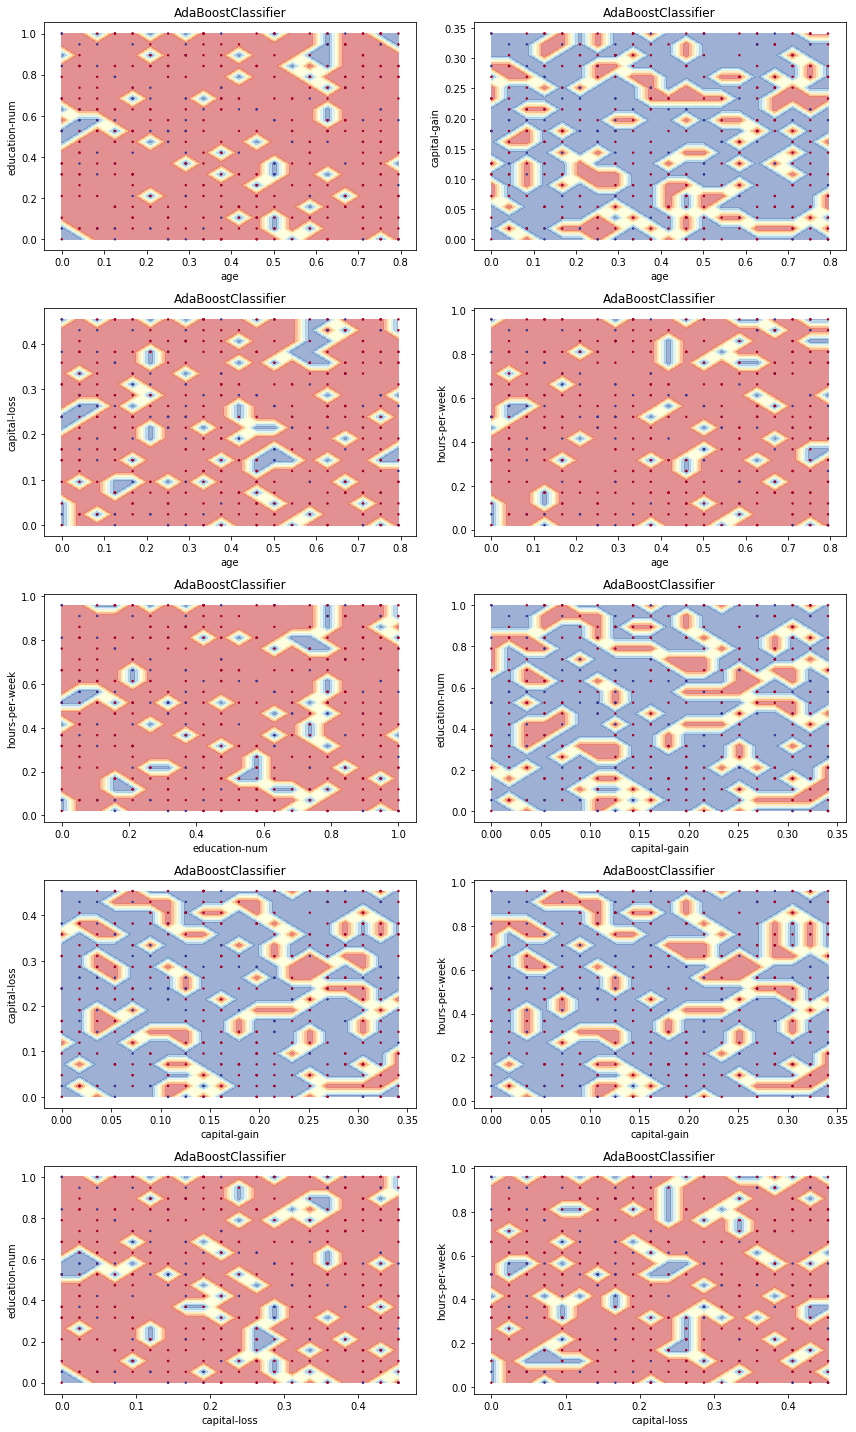

In [53]:
fig, axes = plt.subplots(int(len(numerical)),2,figsize=(12,20))

i_n = 0
j_n = 0
for i in numerical:
    for j in numerical:
        if i < j:
            plotModel(clf_B, X_train, i, j, axes[i_n][j_n], 20)
            j_n += 1
            if j_n == 2:
                j_n = 0
                i_n += 1
plt.tight_layout()

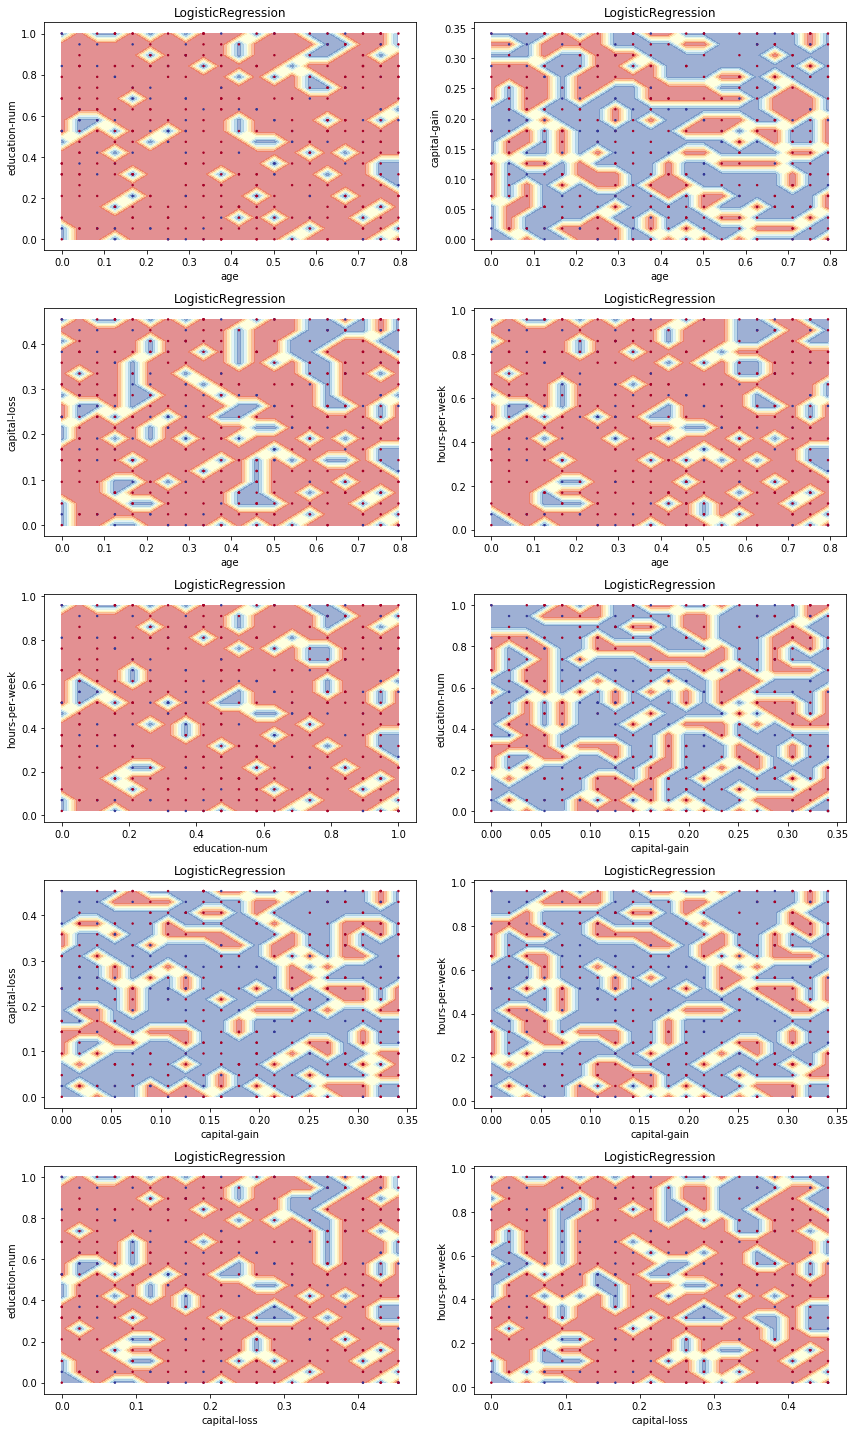

In [54]:
fig, axes = plt.subplots(int(len(numerical)),2,figsize=(12,20))

i_n = 0
j_n = 0
for i in numerical:
    for j in numerical:
        if i < j:
            plotModel(clf_C, X_train, i, j, axes[i_n][j_n], 20)
            j_n += 1
            if j_n == 2:
                j_n = 0
                i_n += 1
plt.tight_layout()

**Comments:**

-  AdaBoost received the best accuracy and F1 scores for the full training set. However, it was also the most time-consuming method for training by a large margin.
-  Decision Tree received the best scores for a small training set but it is badly overfitting.
-  Logistic regression demanded much less resources for training with the full dataset but it received scores similar to AdaBoost and higher than Decision Tree.

### Learning Curve Analysis

In [55]:
from sklearn.model_selection import learning_curve

In [56]:
'''
This function plots the learning curve for a given model.

INPUT:
    model - instantiated sklearn model
    X - numpy array or pandas dataframe with training features
    y - numpy array or pandas dataframe with target values
    
OUTPUT:
    graph with learning curves (Training scores and Testing scores)
    
'''
def plotLearning(model,X,y):
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X,
                                                            y,
                                                            cv=3,
                                                            n_jobs=-1,
                                                            shuffle=True,
                                                       train_sizes=np.linspace(.1, 1.0, 10),
                                                           scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fig, ax = plt.subplots(1)
    
    ax.grid()
    ax.fill_between(train_sizes, 
                 train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, 
                 alpha=0.1, 
                 color='r')
    
    ax.set_xlabel('Elements in Training Set')
    ax.set_ylabel('F1 Score')
    ax.set_title(str(model.__class__.__name__))
    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training scores')
    plt.legend()
    ax.fill_between(train_sizes,
                test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std,
                alpha=0.1,
                color='b')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='b', label='Testing scores')
    plt.legend()

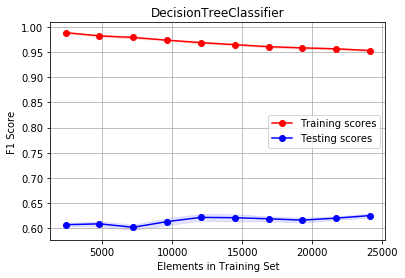

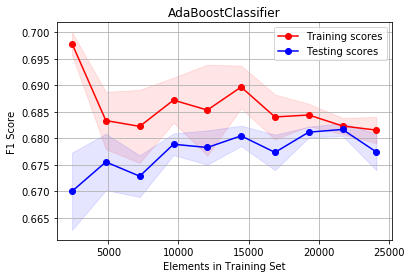

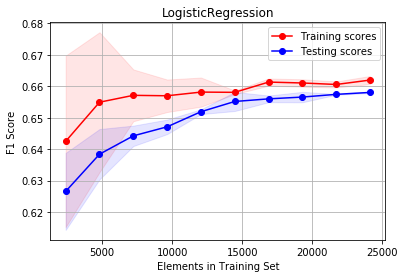

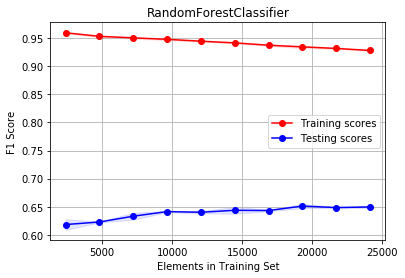

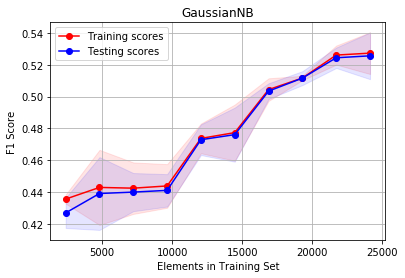

In [57]:
# plot learning curves for all models
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    plotLearning(clf, X_train, y_train)

**Comments:** 

-  F1 score was used for learning curves because accuracy is not a good metric for this problem.
-  Decision Tree is overfitting
-  AdaBoost and Logistic Regression show balanced learning curves. However, the score for AdaBoost is higher.
-  Learning curve for GaussianNB showed improved with the number of elements.

### Chosen model:

AdaBoost is the chosen model for this problem. It returned the best F1 score with the complete training set.

-  accuracy score with full training set: 0.830000 	
-  F1 score with full training set: 0.67418

In [58]:
clf_raw = clf_B
acc_raw = cross_val_score(clf_raw, X_train, y_train, cv=3, scoring='accuracy').mean()

In [59]:
f1_raw = cross_val_score(clf_raw, X_train, y_train, cv=3, scoring='f1').mean()

In [60]:
print('Accuracy score was {:.3f} and F1 score was {:.3f} for raw AdaBoost.'.format(acc_raw, f1_raw))

Accuracy score was 0.856 and F1 score was 0.677 for raw AdaBoost.


## Improving Results

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import calibration_curve
from sklearn.model_selection import cross_val_predict

### Random Search

We performed first random search to probe different regions of the configuration space and to define a subset of parameters for a more detailed search.

In [62]:
# parameters for random search
parameters = {"n_estimators": np.arange(100,2000,100),
            "learning_rate": np.arange(0.1,1.2,0.1),
              "algorithm":['SAMME','SAMME.R'],
              "base_estimator": [DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),
            DecisionTreeClassifier(max_depth=3)]  
}

In [63]:
# perform 60 iterations of random search
random_obj = RandomizedSearchCV(clf_raw, param_distributions=parameters, n_iter = 60)
random_obj.fit(X_train, y_train)

/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=34),
          fit_params=None, iid='warn', n_iter=60, n_jobs=None,
          param_distributions={'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]), 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]), 'algorithm': ['SAMME', 'SAMME.R'], 'base_estimator':...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [64]:
# best random search estimator
clf_random = random_obj.best_estimator_
clf_random

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.7000000000000001, n_estimators=1400,
          random_state=34)

In [65]:
# accuracy of random estimator
acc_random = random_obj.best_score_
acc_random

0.8686181828233408

In [66]:
# f1 score for random estimator
f1_random = cross_val_score(clf_random, X_train, y_train, cv=3, scoring='f1').mean()
f1_random

0.7116137778352741

In [67]:
print('Raw model')
print('Accuracy score was {:.3f} and F1 score was {:.3f} for raw AdaBoost.'.format(acc_raw, f1_raw))
print('Random search model')
print('Accuracy score was {:.3f} and F1 score was {:.3f} for raw AdaBoost.'.format(acc_random, f1_random))

Raw model
Accuracy score was 0.856 and F1 score was 0.677 for raw AdaBoost.
Random search model
Accuracy score was 0.869 and F1 score was 0.712 for raw AdaBoost.


**The random model improved the raw model.**

### Grid Search

We now performed grid search around the best result found by random search.

In [68]:
parameters = {"n_estimators": np.arange(1400,1600,20),
            "learning_rate": np.arange(0.6,0.8,0.02)
           }

In [69]:
# Define a F1 scorer that will evaluate the quality of solutions found in the grid
scorer = make_scorer(fbeta_score, beta=1.0)

In [70]:
# Generate a object for grid search
grid_obj = GridSearchCV(clf_random, param_grid = parameters, cv=3, scoring=scorer, n_jobs=2)

In [71]:
# Run grid on training set
grid_obj.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_...r='best'),
          learning_rate=0.7000000000000001, n_estimators=1400,
          random_state=34),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'n_estimators': array([1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580]), 'learning_rate': array([0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=1.0), verbose=0)

In [72]:
# Select the instance with the best perfomance
clf_grid = grid_obj.best_estimator_
clf_grid

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.7600000000000001, n_estimators=1560,
          random_state=34)

In [73]:
# f1 score improve
f1_grid = grid_obj.best_score_
f1_grid

0.7126673981185697

In [74]:
acc_grid = cross_val_score(clf_grid, X_train, y_train, cv=3, scoring='accuracy').mean()
acc_grid

0.868866959670509

In [75]:
print('Raw model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_raw, f1_raw))
print('Random search model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_random, f1_random))
print('Grid search model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_grid, f1_grid))

Raw model
Accuracy score was 0.8559 and F1 score was 0.6774 for raw AdaBoost.
Random search model
Accuracy score was 0.8686 and F1 score was 0.7116 for raw AdaBoost.
Grid search model
Accuracy score was 0.8689 and F1 score was 0.7127 for raw AdaBoost.


There was a slight improvement using grid search.

### Calibrated model

In [76]:
from sklearn.calibration import CalibratedClassifierCV

In [77]:
clf_calibr = CalibratedClassifierCV(clf_grid, cv=3)
clf_calibr.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1,...r='best'),
          learning_rate=0.7600000000000001, n_estimators=1560,
          random_state=34),
            cv=3, method='sigmoid')

In [78]:
acc_calibr = cross_val_score(clf_calibr, X_train, y_train, cv=3).mean()
acc_calibr

0.868479973463803

In [79]:
f1_calibr = cross_val_score(clf_calibr, X_train, y_train, cv=3, scoring='f1').mean()
f1_calibr

0.7056854225426662

In [80]:
calibr_proba = cross_val_predict(clf_calibr, X_train, y_train, cv=3, method='predict_proba')

In [81]:
fop, mpv = calibration_curve(y_train, calibr_proba[:,1], n_bins=10, normalize=True)

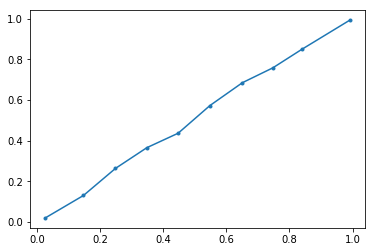

In [82]:
plt.plot(mpv, fop, marker='.')

In [83]:
print('Raw model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_raw, f1_raw))
print('Random search model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_random, f1_random))
print('Grid search model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_grid, f1_grid))
print('Calibrated model')
print('Accuracy score was {:.4f} and F1 score was {:.4f} for raw AdaBoost.'.format(acc_calibr, f1_calibr))

Raw model
Accuracy score was 0.8559 and F1 score was 0.6774 for raw AdaBoost.
Random search model
Accuracy score was 0.8686 and F1 score was 0.7116 for raw AdaBoost.
Grid search model
Accuracy score was 0.8689 and F1 score was 0.7127 for raw AdaBoost.
Calibrated model
Accuracy score was 0.8685 and F1 score was 0.7057 for raw AdaBoost.


The calibrated model slightly underperformed when compared to the grid model. We therefore take the grid model as the best model but we will also test the calibrated model with the test data to check if it generalizes better.

In [84]:
clf_best = clf_grid

------
## Evaluation of the best model

We will now apply tests to evaluate the best model.

### ROC curve for best model

In [85]:
clf_best_proba = cross_val_predict(clf_best, X_train, y_train, cv=3, method='predict_proba')

In [86]:
fpr, tpr, _ = roc_curve(y_train, clf_best_proba[:,1])

In [87]:
roc_auc = auc(fpr, tpr)
print('The area under the ROC curve is: ',roc_auc)

The area under the ROC curve is:  0.925505558564374


Text(0, 0.5, 'True Positive Rate')

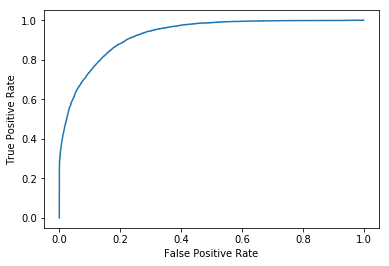

In [88]:
plt.plot(fpr, tpr);
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The ROC curve shows that the model is better than random guessing but the classifier is far from perfect.

### Precision Recall curve

In [89]:
from sklearn.metrics import precision_recall_curve

In [90]:
y_train_proba = clf_best.predict_proba(X_train)

In [91]:
y_train_proba.shape

(36177, 2)

In [92]:
y_train.shape

(36177,)

In [93]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_proba[:,1])

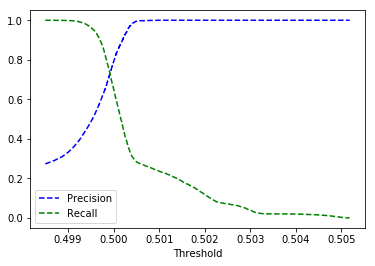

In [94]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g--', label="Recall")
plt.xlabel("Threshold")
plt.legend()

Threshold is located at 0.5. Was that obvious?

### Permutation score

Now we calculated the p-value for the F1 score calculated for the model. 

In [95]:
from sklearn.model_selection import permutation_test_score

In [96]:
score, permutation_scores, pvalue = permutation_test_score(
    clf_best, X_train, y_train, scoring="f1", cv=3, n_permutations=10, n_jobs=1)

In [97]:
score, pvalue

(0.7126673981185698, 0.09090909090909091)

The p-value is calculated as (C + 1) / (n_permutations + 1) where C is the number of permutations where the score is higher than the true score. Therefore the best possible value is 1 / (n_permutations + 1) = 1 / 11 = 0.0909. We conclude that the score calculated is significative. 

### Confusion matrix

In [98]:
from sklearn.metrics import confusion_matrix

In [99]:
y_train_pred = cross_val_predict(clf_best, X_train, y_train, cv=3)

In [100]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[25550,  1624],
       [ 3120,  5883]])

Confusion matrix shows a high number of false negatives. This certainly demands some investigation if some aspect of data cleaning was overlooked.

### Voting classifier

In [101]:
from sklearn.ensemble import VotingClassifier

In [102]:
clf_A = DecisionTreeClassifier(random_state=34)
clf_B = AdaBoostClassifier(random_state=34)
clf_C = LogisticRegression(random_state=34)
clf_D = RandomForestClassifier(random_state=34)
clf_E = GaussianNB()

In [103]:
#clf_voting = VotingClassifier(estimators=[('calibr', clf_calibr),
#                                          ('logReg', clf_C)], voting='hard')

In [104]:
# voting soft requires calibrated classifiers
clf_voting = VotingClassifier(estimators=[('calibr', clf_calibr),('logReg', clf_C)], voting='soft')

In [105]:
clf_voting.fit(X_train, y_train)

/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier(estimators=[('calibr', CalibratedClassifierCV(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impuri..., penalty='l2', random_state=34, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [106]:
f1_voting = cross_val_score(clf_voting, X_train, y_train, cv=3, scoring='f1').mean()
f1_voting

/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bmartins/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7031238741335675

No improvement here. Classifier clf_grid is still the best one.

## Scoring with Testing set

Now we finally applied the test set to assess the best classifier.

In [107]:
acc_test = clf_best.score(X_test, y_test) # this is accuracy
acc_test

0.8678828081813157

In [108]:
f1_test = f1_score(y_test, clf_best.predict(X_test))
f1_test

0.7019206784734348

In [109]:
f1_score(y_test, clf_calibr.predict(X_test))

0.6997481108312342

In [110]:
acc_raw_test = clf_raw.score(X_test, y_test) # this is accuracy
acc_raw_test

0.8576008844665561

In [111]:
f1_raw_test = f1_score(y_test, clf_raw.predict(X_test)) # this is accuracy
f1_raw_test

0.6739240506329114

In [112]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(acc_raw_test))
print("F-score on testing data: {:.4f}".format(f1_raw_test))
print("\nOptimized optimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(acc_test))
print("Final F-score on the testing data: {:.4f}".format(f1_test))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.6739

Optimized optimized Model
------
Final accuracy score on the testing data: 0.8679
Final F-score on the testing data: 0.7019


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

In [113]:
clf_best.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.7600000000000001, n_estimators=1560,
          random_state=34)

In [114]:
# Construct dataframe containing feature labels and their weights
feature_importances = pd.DataFrame(clf_best.feature_importances_, 
                                   index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

In [115]:
feature_importances.head(n=5)

,importance
capital-gain,0.457692
capital-loss,0.353205
age,0.053205
hours-per-week,0.035256
education-num,0.008974


In [116]:
feature_importances.reset_index(inplace=True)

In [117]:
# Add cumulative sum of weights as a separate column
feature_importances['cumsum'] = np.cumsum(feature_importances['importance'])

In [118]:
feature_importances.head()

,index,importance,cumsum
0,capital-gain,0.457692,0.457692
1,capital-loss,0.353205,0.810897
2,age,0.053205,0.864103
3,hours-per-week,0.035256,0.899359
4,education-num,0.008974,0.908333


In [119]:
importance = clf_best.feature_importances_

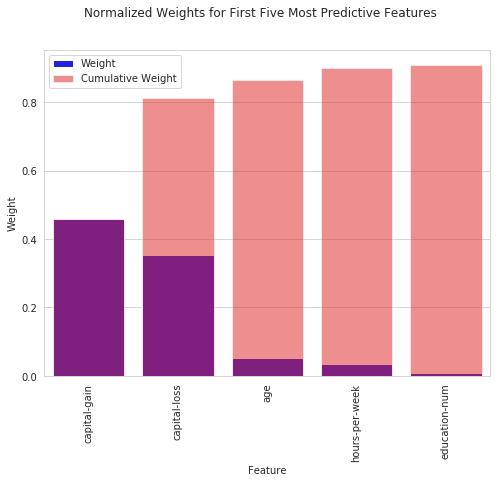

In [120]:
with sns.axes_style('whitegrid',{'axes.facecolor':'white'}):
    fig, axis = plt.subplots(1,1, figsize=(8,6))
    plt.suptitle('Normalized Weights for First Five Most Predictive Features')
    sns.barplot(x='index',
                y='importance',
                data=feature_importances.iloc[:5], 
                ax=axis, 
                color='blue', 
                ci=None, label='Weight')
    sns.barplot(x='index',
                y='cumsum',
                data=feature_importances.iloc[:5], 
                ax=axis, 
                color='red', 
                alpha=0.5, 
                ci=None, label='Cumulative Weight')
    plt.xticks(rotation=90)
    plt.legend()
    axis.set_xlabel('Feature')
    axis.set_ylabel('Weight')

Capital gain and capital loss are the features that are the most important to explain the variance.

### Feature Selection

In [121]:
from sklearn.base import clone

In [122]:
# Colect the first five columns in descending order of importance
X_train_reduced = X_train[X_train.columns.values[np.argsort(importance)[::-1][:5]]]

In [123]:
# Clone best model obtained above and train it with reduced training set
clf_fs = (clone(clf_best)).fit(X_train_reduced, y_train)

In [124]:
# Predictions with reduced test set
f1_fs = cross_val_score(clf_fs, X_train_reduced, y_train, cv=3, scoring='f1').mean()

In [125]:
acc_fs = cross_val_score(clf_fs, X_train_reduced, y_train, cv=3, scoring='accuracy').mean()

In [126]:
# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on CV: {:.4f}".format(acc_grid))
print("F-score on CV: {:.4f}".format(f1_grid))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on CV: {:.4f}".format(acc_fs))
print("F-score on CV: {:.4f}".format(f1_fs))

Final Model trained on full data
------
Accuracy on CV: 0.8689
F-score on CV: 0.7127

Final Model trained on reduced data
------
Accuracy on CV: 0.8400
F-score on CV: 0.5948


### RFE feature selection

In [127]:
from sklearn.feature_selection import RFE

In [128]:
clf_RFE = RFE(clf_best, 5, step = 1)

In [129]:
clf_RFE.fit(X_train, y_train)

RFE(estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_...r='best'),
          learning_rate=0.7600000000000001, n_estimators=1560,
          random_state=34),
  n_features_to_select=5, step=1, verbose=0)

In [130]:
X_train.columns[clf_RFE.support_].value

AttributeError: 'Index' object has no attribute 'value'

In [ ]:
acc_rfe = clf_RFE.score(X_train, y_train)

In [ ]:
f1_rfe = cross_val_score(clf_RFE, X_train, y_train, cv=3, scoring='f1').mean()
f1_rfe

### Select K Best

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
from sklearn.feature_selection import chi2

In [ ]:
clf_kb = (clone(clf_best))

In [ ]:
X_train2 = X_train.copy()

In [ ]:
X_train2 = SelectKBest(chi2, k=5).fit_transform(X_train2, y_train)

In [ ]:
clf_kb.fit(X_train2, y_train)

In [ ]:
cross_val_score(clf_kb, X_train2, y_train, cv=3, scoring='f1').mean()

### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 15)

In [ ]:
X_train2 = X_train.copy()

In [ ]:
pca.fit(X_train2)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
X_pca = pca.fit_transform(X_train2)

In [ ]:
cross_val_score(clf_best, X_pca, y_train, cv=3, scoring='f1').mean()

In [ ]:
import dill
dill.dump_session('finding_donors.db')

### TODO

-  Feature selection improved - done
-  Plot classification results - done
-  calculate p-value for score - done
-  calculate p-value for coefficients of logistic regression
-  ROC curve
-  AdaBoost Grid SearchCV - try optmizing trees - done
- print adaboost tree - not possible

### TODO - Naive Bayes

-  sklearn.calibration.CalibratedClassifierCV
   -   https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV
-  multinomialNB for categorical and GaussianNB for numerical. Multiply predict_proba or use probabilities as input ofr another GaussianNB classification.